In [1]:
import os
import shutil
import PIL
from PIL import Image
import glob as gb
import numpy as np
import pandas as pd
import pylab as plt
from tqdm import tqdm
import model.resnet50_128 as model
from pytorch_feature_extractor import initialize_model, image_encoding
from sklearn.model_selection import train_test_split
from facenet_pytorch import MTCNN, InceptionResnetV1,fixed_image_standardization, training, extract_face
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

CUDA is available!  Training on GPU ...


In [2]:
base_folder = '/home/care1e55/study/MIPT/cv/data/'
folder1 = base_folder + 'folder1/'
test_folder = base_folder + 'test_data/test_data/'
names_file = base_folder + 'class_mapping.csv'


# THIS ONLY RINS ONCE - PREPARING MAPPING FACES FOR PREDICTION
# !mkdir '/home/care1e55/study/MIPT/cv/data/folder1/'
# move 1 image from each class for prediction
# for i in sample:
#     shutil.copy(i[1], folder1+i[1].split('/')[-1])

names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: test_folder+f'{x}')

# prepare datasets for testing
sample = []
for i in range(500):
    row = names[names['class'] == i].iloc[0]
    sample.append((row['class'], row['image']))

images1 = gb.glob(folder1 + '*.jpg')

In [3]:
def predict(folder1:str, folder2:str) -> list:
    images1 = gb.glob(folder1 + '*.jpg')
    images2 = gb.glob(folder2 + '*.jpg')
    model_eval = initialize_model()
    folder1_face_feats = image_encoding(model_eval, images1)
    folder2_face_feats = image_encoding(model_eval, images2)
    
    # using cosine similarity score (dot product)
    S = np.dot(folder2_face_feats, folder1_face_feats.T)

    return [(images2[i], images1[images.argmax()]) for i, images in enumerate(S)]

In [4]:
!pip list | grep facenet

facenet-pytorch               2.4.1


In [5]:
predictions = predict(folder1, test_folder)

100%|██████████| 10588/10588 [1:47:15<00:00,  1.65it/s]


In [6]:
import pickle
with open('predictions_12_1.pickle', 'wb') as f:
    pickle.dump(predictions, f)

In [7]:
# Now visizalize and predict
names = pd.read_csv(names_file, delimiter=',', names=['image', 'class'], skiprows=1)
names['image'] = names['image'].apply(str).apply(lambda x: x.split('.')[0])

In [8]:
class FaceImagesClassDataset(Dataset):
    """
    Images Dataset only for printing
    """
    def __init__(self, predictions, names):
        super().__init__()

        self.predictions = predictions
        self.names = names

    def load_sample(self, file):
        image = Image.open(file).convert('RGB')
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image
    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        predicted = self._prepare_sample(self.load_sample(self.predictions[index][0]))
        source = self._prepare_sample(self.load_sample(self.predictions[index][1]))
        
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]
        return predicted, source, predicted_class, predicted_class
    

In [9]:
face_images_class_dataset = FaceImagesClassDataset(predictions, names)

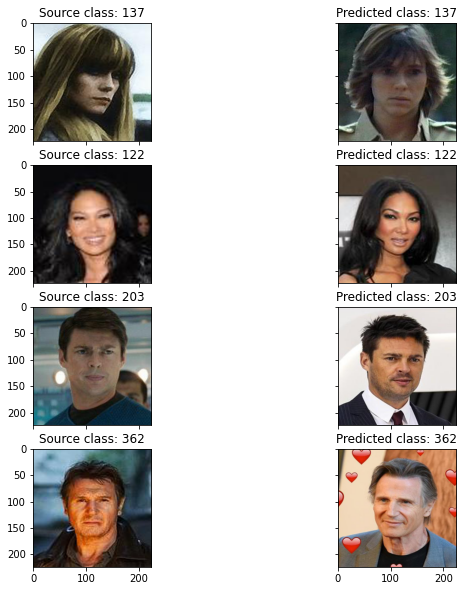

In [13]:
Ni = 4
RESCALE_SIZE = 224

fig, ax = plt.subplots(nrows=Ni, ncols=2,figsize=(10, 10), \
                        sharey=True, sharex=True)

for i in range(Ni):
    for fig_x in ax.flatten():
        random_characters = int(np.random.uniform(0, len(predictions)))
        source, predicted, source_class, predicted_class = face_images_class_dataset[random_characters]
        
        ax[i ,0].imshow(source)
        ax[i ,0].set_title('Source class: ' + str(source_class))
        ax[i ,1].imshow(predicted)
        ax[i ,1].set_title('Predicted class: ' + str(predicted_class))

In [14]:
# Make submission

class FaceClassDataset(Dataset):
    """
    Class Dataset only for accuracy score 
    """
    def __init__(self, predictions, names):
        super().__init__()
        self.predictions = predictions
        self.names = names

    
    def __len__(self):
         return len(predictions)
  
    def __getitem__(self, index):
        source_num = predictions[index][0].split('/')[-1].split('.')[-2]
        predicted_num = predictions[index][1].split('/')[-1].split('.')[-2]
        predicted_class = names[names['image'] == str(predicted_num)]['class'].iloc[0]     
        return str(source_num)+'.jpg', predicted_class
    

In [15]:
face_class_dataset = FaceClassDataset(predictions, names)

In [16]:
final_preds = []
for i, face_pair in tqdm(
    enumerate(face_class_dataset), 
    total = len(face_class_dataset)
):
    final_preds.append(face_pair)

100%|██████████| 169396/169396 [01:18<00:00, 2159.79it/s]


In [19]:
# 0.74117
pd.DataFrame(final_preds).to_csv('oxford_preds_1201_1.csv', header=['Id', 'random'], index=None)